# Modelo de usuarios casuales

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle("data/procesados_casual.pkl")
df.head(1)

,fecha,estacion,año,mes,festivo,dia_semana,clima,temperatura,humedad,viento,casual,casual_box,laboral_no,laboral_sí
0,2018-01-01,0.0,0,0,0,1.0,1,-0.82907,1.268831,-0.212121,331,16.39782,1.0,0.0


In [3]:
df.drop(["fecha", "casual_box"], axis = 1, inplace = True)

In [4]:
# Separamos en X e y.
X = df.drop("casual", axis = 1)
y = df["casual"]

In [8]:
# Separamos en train y test.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
# Instanciamos el método

arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

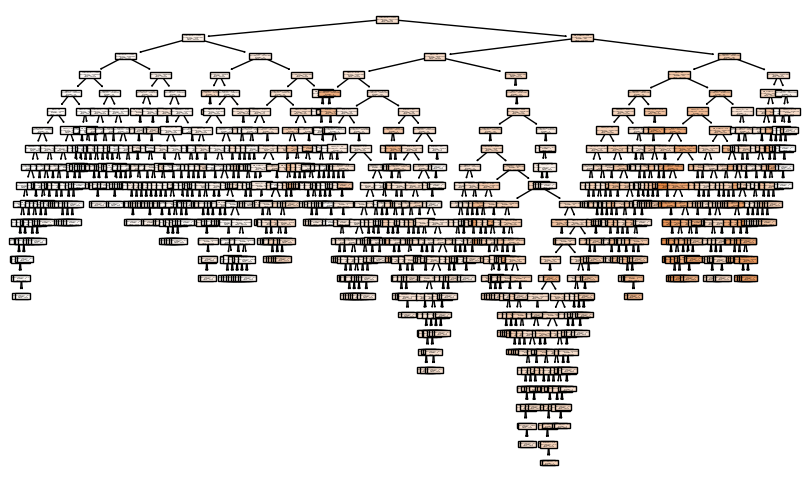

In [8]:
fig = plt.figure(figsize = (10,6))

tree.plot_tree(arbol, feature_names = (x_train.columns).tolist(), filled = True)

plt.show()

In [9]:
# Hacemos las predicciones

y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [15]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """
Esta función nos saca las métricas de nuestro modelo a predecir.
Args: 
    y_test(serie): los datos que tenemos.
    y_train(serie): los datos que ha predicho.
    y_test_pred(serie): los datos que tenemos.
    y_train_pred(serie): los datos que ha predicho.
    tipo_modelo(string): nombre que le damos a nuestro modelo.
Returns: devuelve un dataframe con las métricas.
    """   
    resultados = {"MAE": [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                "MSE": [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                "RMSE": [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                "R2":  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [11]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,413.205479,349397.369863,591.098443,0.272731,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I


Como podemos apreciar en estas métricas, nos encontramos ante un claro caso de overfitting, ya que las métricas de train son perfectas, y test tiene métricas mucho peores. Por tanto, vamos a ajustar los hiperparámetros. 

In [12]:
# Sacamos el cuadrado del número de columnas de train.
max_features = np.sqrt(len(x_train.columns))
max_features

3.3166247903554

In [13]:
# Sacamos la máxima profundidad de nuestro árbol.
print(arbol.tree_.max_depth)

24


In [14]:
# Ajustamos los parámetros.

parametros = {"max_depth": [10,12], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [2,3,4], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [50, 100, 150],
        "min_samples_leaf": [50, 100]}

In [15]:
# Una vez creado el diccionario iniciamos el modelo con GridSearch.

gs_dt1 = GridSearchCV(
            estimator = DecisionTreeRegressor(), 
            param_grid = parametros,
            cv = 10, 
            verbose = 0, 
            return_train_score = True,            
            scoring = "neg_mean_squared_error") 

In [16]:
gs_dt1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 12], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [17]:
mejor_arbol1 = gs_dt1.best_estimator_ 
mejor_arbol1

DecisionTreeRegressor(max_depth=12, max_features=4, min_samples_leaf=50,
                      min_samples_split=50)

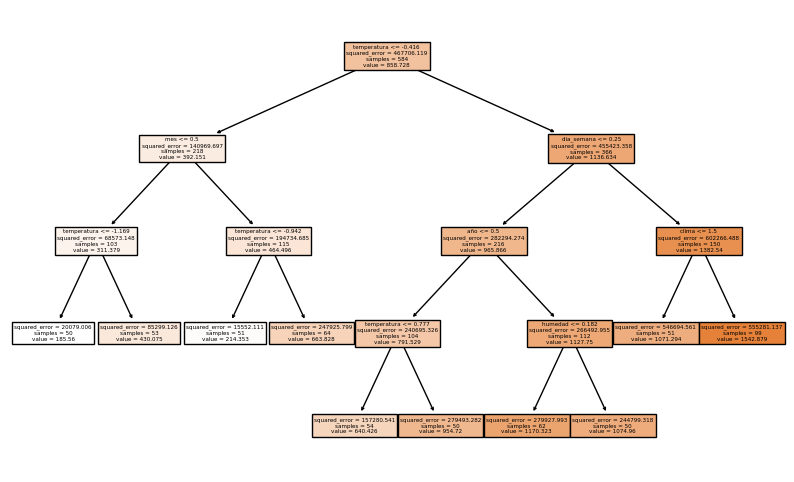

In [18]:
fig = plt.figure(figsize = (10,6))

tree.plot_tree(mejor_arbol1, feature_names = (x_train.columns).tolist(), filled = True)

plt.show()

In [19]:
y_pred_test_dt2 = mejor_arbol1.predict(x_test)
y_pred_train_dt2 = mejor_arbol1.predict(x_train)

In [20]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,341.311432,221939.111676,471.104141,0.538035,test,Decision tree II
1,365.330524,269011.614144,518.663296,0.424828,train,Decision tree II


No nos han salido buenos resultados, vamos a modificar los parámetros.

In [21]:
parametros2 = {"max_depth": [6, 8, 10,12], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [1, 2, 3, 4, 5], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [10, 25, 50],
        "min_samples_leaf": [5, 10, 25]}

In [22]:
gs_dt2 = GridSearchCV(
            estimator = DecisionTreeRegressor(), 
            param_grid = parametros2,
            cv = 10, 
            verbose = 0, 
            return_train_score = True,            
            scoring = "neg_mean_squared_error") 

In [23]:
gs_dt2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10, 12],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [5, 10, 25],
                         'min_samples_split': [10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
mejor_arbol2 = gs_dt2.best_estimator_ 
mejor_arbol2

DecisionTreeRegressor(max_depth=8, max_features=5, min_samples_leaf=5,
                      min_samples_split=25)

In [25]:
y_pred_test_dt3 = mejor_arbol2.predict(x_test)
y_pred_train_dt3 = mejor_arbol2.predict(x_train)

In [26]:
dt_results3 = metricas(y_test, y_train, y_pred_test_dt3, y_pred_train_dt3, "Decision tree III")
dt_results3

,MAE,MSE,RMSE,R2,set,modelo
0,330.453649,229687.120831,479.256842,0.521908,test,Decision tree III
1,275.483501,166994.638644,408.649775,0.642950,train,Decision tree III


Nos han mejorado los resultados, pero siguen sin ser del todo buenos.

In [7]:
parametros3 = {"max_depth": [4, 5, 6, 7], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [4, 5, 6, 7], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [5, 10, 25, 50],
        "min_samples_leaf": [2.5, 5, 10, 25]}

In [28]:
gs_dt3 = GridSearchCV(
            estimator = DecisionTreeRegressor(), 
            param_grid = parametros3,
            cv = 10, 
            verbose = 0, 
            return_train_score = True,            
            scoring = "neg_mean_squared_error") 

In [29]:
gs_dt3.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [2.5, 5, 10, 25],
                         'min_samples_split': [5, 10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
mejor_arbol3 = gs_dt3.best_estimator_ 
mejor_arbol3

DecisionTreeRegressor(max_depth=7, max_features=5, min_samples_leaf=10,
                      min_samples_split=5)

In [31]:
y_pred_test_dt4 = mejor_arbol3.predict(x_test)
y_pred_train_dt4 = mejor_arbol3.predict(x_train)

In [32]:
dt_results4 = metricas(y_test, y_train, y_pred_test_dt4, y_pred_train_dt4, "Decision tree IV")
dt_results4

,MAE,MSE,RMSE,R2,set,modelo
0,370.414209,268309.014518,517.985535,0.441516,test,Decision tree IV
1,334.804641,221487.823290,470.624928,0.526438,train,Decision tree IV


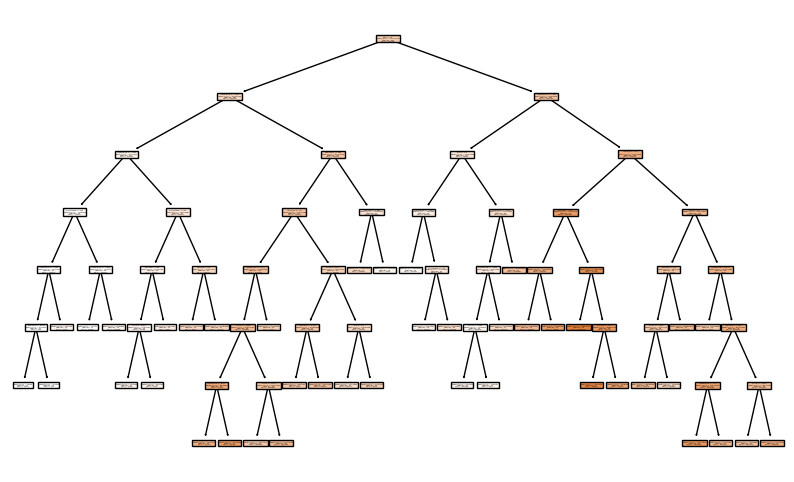

In [33]:
fig = plt.figure(figsize = (10,6))

tree.plot_tree(mejor_arbol3, feature_names = (x_train.columns).tolist(), filled = True)

plt.show()

Siguen sin salir buenas métricas, pasamos a reaizar un *Random Forest*.

In [34]:
gs_rf = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros3, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [35]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': [2.5, 5, 10, 25],
                         'min_samples_split': [5, 10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [36]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=7, max_features=6, min_samples_leaf=5,
                      min_samples_split=5)

In [43]:
parametros3

{'max_depth': [4, 5, 6, 7],
 'max_features': [4, 5, 6, 7],
 'min_samples_split': [5, 10, 25, 50],
 'min_samples_leaf': [2.5, 5, 10, 25]}

In [37]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [38]:
df_resultados3 = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest I")
df_resultados3

,MAE,MSE,RMSE,R2,set,modelo
0,289.989597,170195.987346,412.548164,0.645738,test,Random Forest I
1,259.365728,136360.379789,369.270063,0.708449,train,Random Forest I


In [39]:
df_resultados_total = pd.concat([dt_results1, dt_results2, dt_results3, dt_results4, df_resultados3], axis = 0)
df_resultados_total

,MAE,MSE,RMSE,R2,set,modelo
0,413.205479,349397.369863,591.098443,0.272731,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I
0,341.311432,221939.111676,471.104141,0.538035,test,Decision tree II
1,365.330524,269011.614144,518.663296,0.424828,train,Decision tree II
0,330.453649,229687.120831,479.256842,0.521908,test,Decision tree III
1,275.483501,166994.638644,408.649775,0.642950,train,Decision tree III
0,370.414209,268309.014518,517.985535,0.441516,test,Decision tree IV
1,334.804641,221487.823290,470.624928,0.526438,train,Decision tree IV
0,289.989597,170195.987346,412.548164,0.645738,test,Random Forest I
1,259.365728,136360.379789,369.270063,0.708449,train,Random Forest I


In [42]:
df_resultados_no_scaler = pd.read_csv("../métricas-casual-no-scaler", index_col = 0)
df_resultados_no_scaler

,MAE,MSE,RMSE,R2,set,modelo
0,415.410959,351558.739726,592.923890,0.268232,test,Decision Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decision Tree I
0,356.420518,243531.602573,493.489212,0.493090,test,Decision tree II
1,392.040948,284554.431203,533.436436,0.391596,train,Decision tree II
0,390.218353,306634.980206,553.746314,0.361741,test,Decision tree III
1,340.354206,236141.662438,485.944094,0.495107,train,Decision tree III
0,340.434080,240982.187036,490.899365,0.498397,test,Decision tree IV
1,312.996420,203598.882301,451.219328,0.564686,train,Decision tree IV
0,299.762637,181044.968338,425.493794,0.623156,test,Random Forest I
1,265.165952,142024.149709,376.860916,0.696339,train,Random Forest I


In [40]:
df_resultados_total.to_csv("data/metricas_casuales_scaler.csv")

In [44]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': arbol.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,temperatura,0.391306
7,humedad,0.172386
8,viento,0.128489
4,dia_semana,0.094572
1,año,0.062449
2,mes,0.049168
10,laboral_sí,0.039468
5,clima,0.033303
0,estacion,0.024418
9,laboral_no,0.002775


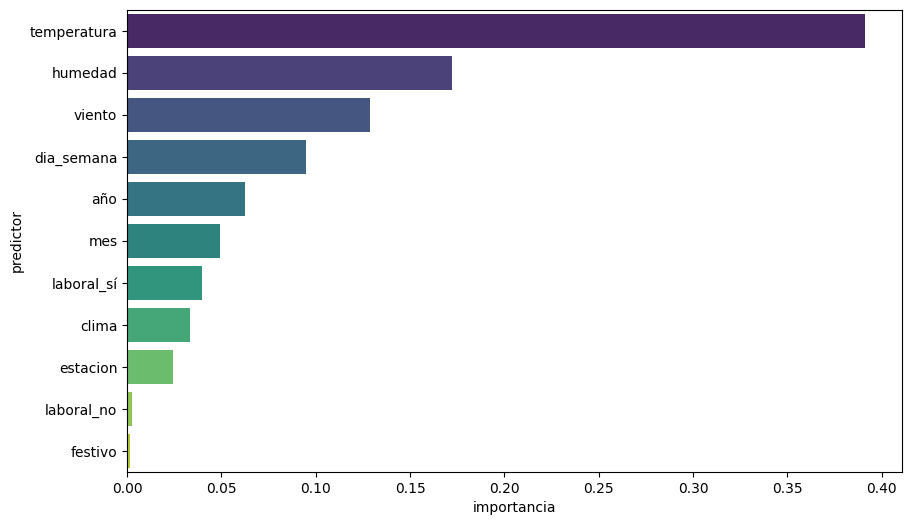

In [45]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

In [35]:
parametros4 = {"max_depth": [4, 5, 6], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [9, 10], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [10, 15, 20],
        "min_samples_leaf": [3, 4, 5]}

In [36]:
gs_rf2 = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros4, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [37]:
gs_rf2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6], 'max_features': [9, 10],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [38]:
bosque3 = gs_rf2.best_estimator_
bosque3

RandomForestRegressor(max_depth=6, max_features=9, min_samples_leaf=3,
                      min_samples_split=15)

In [39]:
y_pred_test_rf4 = bosque3.predict(x_test)
y_pred_train_rf4 = bosque3.predict(x_train)

In [23]:
df_resultados4

,MAE,MSE,RMSE,R2,set,modelo
0,286.698027,166784.608434,408.392713,0.652839,test,Random Forest II
1,258.547833,134438.230457,366.658193,0.712558,train,Random Forest II


In [40]:
df_resultados5 = metricas(y_test, y_train, y_pred_test_rf4, y_pred_train_rf4, "Random Forest IV")
df_resultados5

,MAE,MSE,RMSE,R2,set,modelo
0,291.608483,172496.445647,415.326914,0.640950,test,Random Forest IV
1,268.807387,144030.745310,379.513828,0.692049,train,Random Forest IV


In [41]:
parametros5 = {"max_depth": [4, 5, 6, 7], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [9, 10, 11], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [10, 15, 20],
        "min_samples_leaf": [2, 3, 4, 5]}

In [42]:
gs_rf3 = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros5, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [43]:
gs_rf3.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7], 'max_features': [9, 10, 11],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [44]:
bosque4 = gs_rf3.best_estimator_
bosque4

RandomForestRegressor(max_depth=7, max_features=9, min_samples_leaf=4,
                      min_samples_split=10)

In [45]:
y_pred_test_rf5 = bosque4.predict(x_test)
y_pred_train_rf5 = bosque4.predict(x_train)

In [46]:
df_resultados6 = metricas(y_test, y_train, y_pred_test_rf5, y_pred_train_rf5, "Random Forest IV")
df_resultados6

,MAE,MSE,RMSE,R2,set,modelo
0,283.026435,164867.083745,406.038279,0.656830,test,Random Forest IV
1,246.121478,123879.747531,351.965549,0.735133,train,Random Forest IV


In [47]:
parametros6 = {"max_depth": [4, 5, 6], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [8, 9, 10, 11], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [9, 10, 15, 20],
        "min_samples_leaf": [2, 3, 4, 5]}

In [48]:
gs_rf4 = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros6, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [49]:
gs_rf4.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6], 'max_features': [8, 9, 10, 11],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [9, 10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [51]:
bosque5 = gs_rf4.best_estimator_
bosque5

RandomForestRegressor(max_depth=6, max_features=8, min_samples_leaf=5,
                      min_samples_split=9)

In [52]:
y_pred_test_rf6 = bosque5.predict(x_test)
y_pred_train_rf6 = bosque5.predict(x_train)

In [53]:
df_resultados7 = metricas(y_test, y_train, y_pred_test_rf6, y_pred_train_rf6, "Random Forest IV")
df_resultados7

,MAE,MSE,RMSE,R2,set,modelo
0,296.048480,174055.053414,417.199057,0.637705,test,Random Forest IV
1,266.881378,144806.956885,380.535093,0.690389,train,Random Forest IV


In [62]:
parametros7 = {"max_depth": [4, 5, 6], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [9, 10], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [7, 8, 9, 10, 15, 20],
        "min_samples_leaf": [5, 6, 7, 8]}

In [63]:
gs_rf5 = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros7, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [64]:
gs_rf5.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6], 'max_features': [9, 10],
                         'min_samples_leaf': [5, 6, 7, 8],
                         'min_samples_split': [7, 8, 9, 10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [65]:
bosque6 = gs_rf5.best_estimator_
bosque6

RandomForestRegressor(max_depth=6, max_features=9, min_samples_leaf=7,
                      min_samples_split=10)

In [66]:
y_pred_test_rf7 = bosque6.predict(x_test)
y_pred_train_rf7 = bosque6.predict(x_train)

In [67]:
df_resultados8 = metricas(y_test, y_train, y_pred_test_rf7, y_pred_train_rf7, "Random Forest IV")
df_resultados8

,MAE,MSE,RMSE,R2,set,modelo
0,287.787443,171479.744684,414.101129,0.643066,test,Random Forest IV
1,274.671013,153732.558313,392.087437,0.671305,train,Random Forest IV


In [69]:
parametros8 = {"max_depth": [4, 5, 6], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [10], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [7, 8, 9, 10, 15, 20],
        "min_samples_leaf": [5, 6, 7, 8, 9]}

In [70]:
gs_rf6 = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros8, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [ ]:
gs_rf6.fit(x_train, y_train)

In [72]:
bosque7 = gs_rf6.best_estimator_
bosque7

RandomForestRegressor(max_depth=6, max_features=10, min_samples_leaf=5,
                      min_samples_split=10)

In [73]:
y_pred_test_rf8 = bosque7.predict(x_test)
y_pred_train_rf8 = bosque7.predict(x_train)

In [74]:
df_resultados8 = metricas(y_test, y_train, y_pred_test_rf8, y_pred_train_rf8, "Random Forest IV")
df_resultados8

,MAE,MSE,RMSE,R2,set,modelo
0,282.306394,163911.731237,404.860138,0.658819,test,Random Forest IV
1,261.935232,140171.258383,374.394522,0.700301,train,Random Forest IV


In [82]:
parametros9 = {"max_depth": [6], # tiene 23 de profundidad, así que ponemos como máximo la mitad. 
        "max_features": [11], # la raíz cuadrada es 3.3, así que dejamos hasta 4.
        # hemos tenido en cuenta el nº de filas que tenemos en nuestro conjunto de datos para los siguientes.
        "min_samples_split": [7, 8, 9, 10, 15, 20],
        "min_samples_leaf": [5, 6, 7, 8]}

In [83]:
gs_rf7 = GridSearchCV(
            estimator = RandomForestRegressor(), 
            param_grid = parametros9, 
            cv = 10,  
            verbose = 0, 
            return_train_score = True, 
            scoring = "neg_mean_squared_error")

In [84]:
gs_rf7.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6], 'max_features': [11],
                         'min_samples_leaf': [5, 6, 7, 8],
                         'min_samples_split': [7, 8, 9, 10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [85]:
bosque8 = gs_rf7.best_estimator_
bosque8

RandomForestRegressor(max_depth=6, max_features=11, min_samples_leaf=7,
                      min_samples_split=8)

In [86]:
y_pred_test_rf9 = bosque8.predict(x_test)
y_pred_train_rf9 = bosque8.predict(x_train)

In [87]:
df_resultados9 = metricas(y_test, y_train, y_pred_test_rf9, y_pred_train_rf9, "Random Forest IV")
df_resultados9

,MAE,MSE,RMSE,R2,set,modelo
0,289.780249,170846.936662,413.336348,0.644383,test,Random Forest IV
1,275.873064,154069.519391,392.516903,0.670585,train,Random Forest IV
